# Feature Extraction

We aim to extract power bands from raw EEG signals changes in power in the preictal period has been indicative of an oncoming seizure.
**Source**: [A. Sharma, "Epileptic seizure prediction using power analysis in beta band of EEG signals," 2015 International Conference on Soft Computing Techniques and Implementations (ICSCTI), 2015, pp. 117-121, doi: 10.1109/ICSCTI.2015.7489552.](https://ieeexplore.ieee.org/document/7489552).

In [1]:
import os
import parser as p
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.integrate import simps
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Raw EEG')

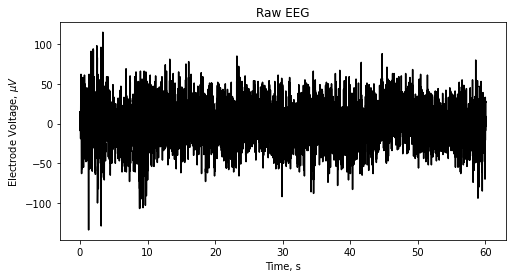

In [2]:
rootdir = "../../../data.nosync/"
filename = "Dog_1_interictal_segment_0001.mat"
path = rootdir + filename
mat = sio.loadmat(path)
data = p.get_data(mat)
channels = p.get_channels(mat)
sampling_frequency = p.get_sampling_frequency(mat)

# select first 1 min of channel 1
n = np.rint(sampling_frequency).astype(int) * (60 * 1)
t = np.arange(0, n) / sampling_frequency
X = data[0,0:n]

# visualise raw EEG
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t, X, 'k')
ax.set_xlabel('Time, s')
ax.set_ylabel(r'Electrode Voltage, $\mu V$')
ax.set_title('Raw EEG')

## The Frequency Domain

We decompose the above signal into its frequency components by performing Fourier transform through FFT. This returns frequencies which have a complex number associated with them that can tell us about the amplitude and phase at a certain frequency. Note that the Fourier transform returns negative frequencies, which does not have a physical interpretation.

In [3]:
fourier = fft(X)
freq = fftfreq(n, d=1/sampling_frequency)

Text(0.5, 1.0, 'Frequency Domain EEG')

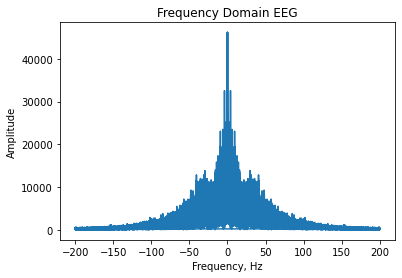

In [4]:
fig, ax = plt.subplots()
ax.plot(freq, np.abs(fourier))
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency Domain EEG')

Suppose we want to see the magnitude and phase at 4 Hz.

In [5]:
# find index of 4 Hz
index, = np.where(np.isclose(freq, 4, atol=(1/(1/sampling_frequency * n))))

print('Magnitude: {magnitude:.2f}'.format(magnitude = np.abs(fourier[index[0]])))
print('Phase (radians): {phase:.2f}'.format(phase = np.angle(fourier[index[0]])))

Magnitude: 2493.81
Phase (radians): 1.45


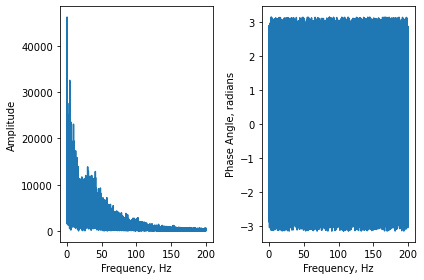

In [6]:
fig, ax = plt.subplots(ncols=2)
# visualise real frequency amplitudes
ax[0].plot(freq[0:n//2], np.abs(fourier[0:n//2]))
ax[0].set_xlabel('Frequency, Hz')
ax[0].set_ylabel('Amplitude')
# visualise real frequency phase
ax[1].plot(freq[0:n//2], np.angle(fourier[0:n//2]))
ax[1].set_xlabel('Frequency, Hz')
ax[1].set_ylabel('Phase Angle, radians')
fig.tight_layout()

## Power Spectral Density

The power spectral density, also known as a power spectrum or periodogram (in signal processing) is obtained from the Fourier transformed signal by taking its magnitude squared. For EEG, the measurement is expressed in $\mu V^2 Hz^{-1}$ for each frequency.

(12001,)
(12001,)


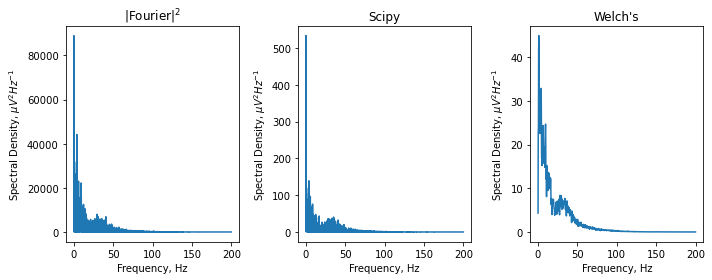

In [20]:
# method A
pgram = 1/n * np.abs(fourier)**2

# method B
f, Pxx_den = signal.periodogram(X, sampling_frequency, window='hann')
print(f.shape)
print(Pxx_den.shape)

# Welch's method
time_window_size = 4 * sampling_frequency
f_welch, Pxx_den_welch = signal.welch(X, sampling_frequency, window='hann', nperseg=time_window_size)

fig, ax = plt.subplots(figsize=(10,4), ncols=3)
ax[0].plot(freq[0:n//2], pgram[0:n//2])
ax[0].set_xlabel('Frequency, Hz')
ax[0].set_ylabel(r'Spectral Density, $\mu V^2 Hz^{-1}$')
ax[0].set_title(r'|Fourier|$^2$')

ax[1].plot(f, Pxx_den)
ax[1].set_xlabel('Frequency, Hz')
ax[1].set_ylabel(r'Spectral Density, $\mu V^2 Hz^{-1}$')
ax[1].set_title('Scipy')

ax[2].plot(f_welch, Pxx_den_welch)
ax[2].set_xlabel('Frequency, Hz')
ax[2].set_ylabel(r'Spectral Density, $\mu V^2 Hz^{-1}$')
ax[2].set_title('Welch\'s')

fig.tight_layout()

## Spectral Bands

There are five broad sub-bands of the EEG signal which are generally of clinical interest: delta (0–4 Hz), theta (4–8 Hz), alpha (8–16 Hz), beta (16–32 Hz), and gamma waves (32–64 Hz). Higher frequencies are often more common in abnormal brain states such as epilepsy, i.e., there is a shift of EEG signal energy from lower to higher frequency bands before and during a seizure. These five frequency sub-bands provide more accurate information about neuronal activities underlying the problem. Consequently, some changes in the EEG signal, which are not so obvious in the original full-spectrum signal, can be amplified when each sub-band is considered independently.

**Source**: [Detection of epileptiform activity in EEG signals based on time-frequency and non-linear analysis (D. Gajic et al, 2015)](https://doi.org/10.3389/fncom.2015.00038)

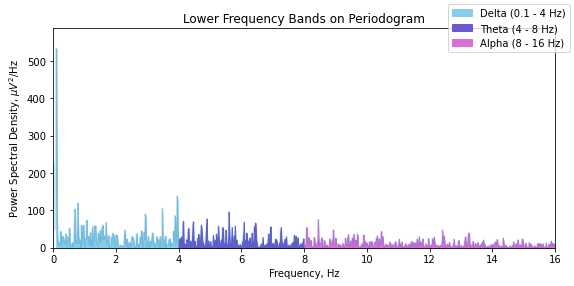

In [57]:
# color delta, theta and alpha frequency band areas under periodogram.
f, Pxx_den = signal.periodogram(X, sampling_frequency, window='hann')

tolerance = (1/(1/sampling_frequency * n)) # param. for determining frequency bin index close to desired frequency

# delta band: 0.1 - 4 Hz
delta_low, delta_high = 0.1, 4
delta_band = np.zeros_like(f, dtype=bool)
delta_index_low, = np.where(np.isclose(f, delta_low, atol=tolerance))
delta_index_high, = np.where(np.isclose(f, delta_high, atol=tolerance))
delta_band[delta_index_low[0] : delta_index_high[0]] = 1

# theta band: 4 - 8 Hz
theta_low, theta_high = 4, 8
theta_band = np.zeros_like(f, dtype=bool)
theta_index_low, = np.where(np.isclose(f, theta_low, atol=tolerance))
theta_index_high, = np.where(np.isclose(f, theta_high, atol=tolerance))
theta_band[theta_index_low[0] : theta_index_high[0]] = 1

# alpha band: 8 - 16 Hz
alpha_low, alpha_high = 8, 16
alpha_band = np.zeros_like(f, dtype=bool)
alpha_index_low, = np.where(np.isclose(f, alpha_low, atol=tolerance))
alpha_index_high, = np.where(np.isclose(f, alpha_high, atol=tolerance))
alpha_band[alpha_index_low[0] : alpha_index_high[0]] = 1

# plot power spectral density and colour the band areas
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(f, Pxx_den, alpha=0.2)
ax.fill_between(f, Pxx_den, where=delta_band, color='skyblue', label='Delta (0.1 - 4 Hz)')
ax.fill_between(f, Pxx_den, where=theta_band, color='slateblue', label='Theta (4 - 8 Hz)')
ax.fill_between(f, Pxx_den, where=alpha_band, color='orchid', label='Alpha (8 - 16 Hz)')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel(r'Power Spectral Density, $\mu V^2$/Hz')
ax.set_xlim([0, 16])
ax.set_ylim([0, Pxx_den.max() * 1.1])
ax.set_title('Lower Frequency Bands on Periodogram')
fig.legend(loc=1)
fig.tight_layout()
plt.show()

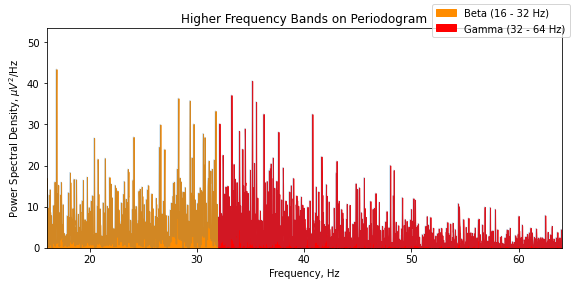

In [63]:
# color beta and gamma frequency band areas under periodogram.
f, Pxx_den = signal.periodogram(X, sampling_frequency, window='hann')

tolerance = (1/(1/sampling_frequency * n)) # param. for determining frequency bin index close to desired frequency

# beta band 16 - 32 Hz
beta_low, beta_high = 16, 32
beta_band = np.zeros_like(f, dtype=bool)
beta_index_low, = np.where(np.isclose(f, beta_low, atol=tolerance))
beta_index_high, = np.where(np.isclose(f, beta_high, atol=tolerance))
beta_band[beta_index_low[0] : beta_index_high[0]] = 1

# gamma band 32 - 64 Hz
gamma_low, gamma_high = 32, 64
gamma_band = np.zeros_like(f, dtype=bool)
gamma_index_low, = np.where(np.isclose(f, gamma_low, atol=tolerance))
gamma_index_high, = np.where(np.isclose(f, gamma_high, atol=tolerance))
gamma_band[gamma_index_low[0] : gamma_index_high[0]] = 1

# plot power spectral density and colour the band areas
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(f, Pxx_den, alpha=0.2)
ax.fill_between(f, Pxx_den, where=beta_band, color='darkorange', label='Beta (16 - 32 Hz)')
ax.fill_between(f, Pxx_den, where=gamma_band, color='red', label='Gamma (32 - 64 Hz)')
ax.set_xlabel('Frequency, Hz')
ax.set_ylabel(r'Power Spectral Density, $\mu V^2$/Hz')
ax.set_xlim([16, 64])
ax.set_ylim([0, Pxx_den.max() * 0.1])
ax.set_title('Higher Frequency Bands on Periodogram')
fig.legend(loc=1)
fig.tight_layout()
plt.show()

### Band Power

Approximating the integral of a band will give the band power. The spacing of integration points along x axis is the frequency resolution, which can be computed by differencing first two frequency bins. Integrals can be approximated using multiple methods, the [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) and the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) are two such methods.

In [76]:
freq_resolution = f[1] - f[0]
print(f'Frequency resolution: {freq_resolution} Hz')
print('---')

total_power = simps(Pxx_den, dx=freq_resolution)

delta_power = simps(Pxx_den[delta_band], dx=freq_resolution)
delta_relative_power = delta_power / total_power


theta_power = simps(Pxx_den[theta_band], dx=freq_resolution)
theta_relative_power = theta_power / total_power


alpha_power = simps(Pxx_den[alpha_band], dx=freq_resolution)
alpha_relative_power = alpha_power / total_power

beta_power = simps(Pxx_den[beta_band], dx=freq_resolution)
beta_relative_power = beta_power / total_power


gamma_power = simps(Pxx_den[gamma_band], dx=freq_resolution)
gamma_relative_power = gamma_power / total_power


print(f'Absolute delta power: {delta_power} micro-V^2')
print(f'Absolute theta power: {theta_power} micro-V^2')
print(f'Absolute alpha power: {alpha_power} micro-V^2')
print(f'Absolute beta power : {beta_power} micro-V^2')
print(f'Absolute gamma power: {gamma_power} micro-V^2')
print('---')
print(f'Relative delta power: {delta_relative_power}')
print(f'Relative theta power: {theta_relative_power}')
print(f'Relative alpha power: {alpha_relative_power}')
print(f'Relative beta power: {beta_relative_power}')
print(f'Relative gamma power: {gamma_relative_power}')

Frequency resolution: 0.01665040650406504 Hz
---
Absolute delta power: 97.43713739956492 micro-V^2
Absolute theta power: 72.36248409711636 micro-V^2
Absolute alpha power: 77.708023284664 micro-V^2
Absolute beta power : 94.85408782958984 micro-V^2
Absolute gamma power: 107.93941971842447 micro-V^2
---
Relative delta power: 0.19778022203483414
Relative theta power: 0.14688309358915685
Relative alpha power: 0.15773359634021364
Relative beta power: 0.1925370842218399
Relative gamma power: 0.2190980048056756


In [ ]:
# perform comparison of two feature extraction methods: periodogram vs Welch?
